In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.color import rgb2gray
from skimage import feature, color

In [2]:
def harris_corner_detection(image):
    '''
        This function takes in an image and returns the corners detected using the Harris Corner Detection algorithm.
    '''
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    corners = corner_peaks(corner_harris(image_gray), threshold_rel=.01)
    
    # Plot the corners
    plt.figure(figsize=(5,5))
    plt.imshow(image, cmap='gray')
    plt.title('Harris Corner Detection')
    plt.plot(corners[:, 1], corners[:, 0], '+', markersize=10)
    plt.axis('off')
    plt.show()
  
    return corners 


In [3]:
def get_patches(corners, img, patch_size):
    '''
    Get patches that decribe the detected corners. 
    corners: list of corners
    img: image
    patch_size: size of patch
    '''
    keypoints = []
    descriptions = []
    patches = []
    # if the patch is out of the image, skip it
    for y, x in corners:
        if ((y + patch_size) > img.shape[0]) or ((x + patch_size ) > img.shape[1]) or ((y - patch_size) < 0) or  ((x - patch_size) < 0 ):
            continue
        
        # Extract description from patch
        patch = img[(y - patch_size): (y + patch_size) , (x - patch_size): (x + patch_size) ]
        # we need to flatten the patch because we compute the distances on vector forms and not on the matrix forms
        description = patch.flatten()
        keypoints.append(np.array([y, x]))
        descriptions.append(description)
        #return also the patch to plot it 
        patches.append(patch)

    return np.array(keypoints), np.array(descriptions), np.array(patches)

In [4]:
def get_patches_sift(corners, img, patch_size):
    '''
    Apply Scale Invariant Feature Transform (SIFT) to get patches from image, based on the corners detected by harris corner 
        corners: list of corners (y, x) from harris corner detection
        img: image
        patch_size: patch size

        return: keypoints, descriptions, patches
    '''
    keypoints = []
    descriptions = []
    patches = []
    # Create SIFT object
    sift = cv2.SIFT_create()

    for y, x in corners:
        # Check if patch is out of bounds, skip
        if ((y + patch_size) > img.shape[0]) or ((x + patch_size) > img.shape[1]) or ((y - patch_size) < 0) or  ((x - patch_size) < 0 ):
            continue
        # Extract patch from image
        patch = img[(y - patch_size): (y + patch_size), (x - patch_size): (x + patch_size)]
        kp, desc = sift.detectAndCompute(patch, None)
        
        keypoints.extend([kp[i].pt for i in range(len(kp))])
        descriptions.extend(desc)
        patches.extend([patch] * len(kp))

    return np.array(keypoints), np.array(descriptions), np.array(patches)

In [5]:
def plot_patches(patches):
   '''
   Plots the first 10 patches from the given list of patches.
   '''
   fig = plt.figure(figsize=(10, 10))
   for i, patch in enumerate(patches[:10]):
        plt.subplot(2, 5, i+1)
        plt.imshow(patch, cmap='gray')
        plt.title(f'Patch {i+1}')
        plt.axis('off')
        
        plt.tight_layout()
   plt.show()

In [6]:
def compute_distances(descriptions1, descriptions2, euclidean=True):
    '''
    computes the distances between the descriptions  keypoints extracted from  two images. 
    :param descriptions1: descriptions of the first image
    :param descriptions2: descriptions of the second image
    :param euclidean: whether to use Euclidean distance or correlation
    '''
    descriptions1 = np.array([(x - x.min()) / (x.max() - x.min()) for x in descriptions1])
    descriptions2 = np.array([(x - x.min()) / (x.max() - x.min()) for x in descriptions2])

    distances = []
    # Compute distances between all pairs of keypoints
    for i, desc1 in enumerate(descriptions1):
        for j, desc2 in enumerate(descriptions2):
            if euclidean:
                # Compute Euclidean distance
                dist = np.linalg.norm(desc1 - desc2)
            else:
                # Compute correlation
                norm_corr = np.dot(desc1, desc2) / (np.linalg.norm(desc1) * np.linalg.norm(desc2))
                dist = 1 - norm_corr
                
            distances.append(np.array([dist, i, j]))
    distances = np.array(distances)
    return distances


In [7]:
def select_best_matches(dist, use_top_k=True, k=None, threshold=None):
    '''
        Select the best matches from the distance matrix.
        If use_top_k is True, return the top k matches.
        If use_top_k is False, return all matches with distance <= threshold.
    '''
    if use_top_k:
        #sort ascending according to distance
        order = np.argsort(dist[:, 0])
        #select top k
        order = order[:k]
        matches = dist[order]
        return matches
    else:
        ##select all matches with distance <= threshold
        matches = dist[dist[:, 0] <= threshold]
        return matches


In [8]:
def convert_to_cv2_keypoints(keypoints_array):
    #for plotting the matchings, we need keypoints as cv2 keypoints objects 
    keypoints = []
    #converting the keypoints array to cv2 keypoints
    for point in keypoints_array:
        x, y = point
        keypoints.append(cv2.KeyPoint(float(y), float(x), 1))
    return keypoints

def plot_matches(img1, img2, keypoints1, keypoints2, matches):
    '''
        Plots the matches between the two images.
    '''
  
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    keypoints1 = convert_to_cv2_keypoints(keypoints1)
    keypoints2 = convert_to_cv2_keypoints(keypoints2)

    dmatches = [cv2.DMatch(i, i, 0) for i in range(len(matches))]
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, dmatches, None)
    f = plt.figure(figsize=(12, 12))
    plt.imshow(img_matches)
    plt.show()

In [9]:
def sample(s,src,dst): 
    '''
    given source and destination points, randomly sample s matches to start with, 
    they are going to be our first s inliers. 
    '''
    indices = np.random.choice(src.shape[0], size=s, replace=False)
    src = src[indices]
    des = dst[indices]
    return src, des,indices

def find_inliers(remaining_src,remaining_des,remaining_indices,x):
    '''
    given non-sampled keypoints, find the other possible inliers. 
    we compare the Euclidean distance between the predicted destination keypoint by the model and the actual destination keypoint.
    '''
    inliers_indices = []
    inliers_dist = []
    #  for each remaining keypoint
    for i in range(len(remaining_src)):
        src = remaining_src[i]
        des = remaining_des[i]

        src_x, src_y = src
        ##  predict the destination keypoint using the model
        des_pred = np.dot(np.array([
            [src_x, src_y,1],
            [src_x, src_y,1]
            ]), x.T)
        # compute the euclidean distance between the actual destination and the predicted 
        dist = np.linalg.norm(des - des_pred)
        if dist <= 1:
            inliers_indices.append(remaining_indices[i])
            inliers_dist.append(dist)

    return  inliers_dist,inliers_indices



def get_affine(matches, keypoints1 , keypoints2,s = 3,num_iter= 1000):
    '''
    this function is the skeleton of the RANSAC algorithm 

    '''

    #first we need to extract the source and destination points, and they have the corrds of the corresponding keypoints 
    src_points = np.array([[keypoints1[int(i)][1], keypoints1[int(i)][0]] for x, i, z in matches])
    des_points = np.array([[keypoints2[int(i)][1], keypoints2[int(i)][0]] for x, z, i in matches])

    #initialize the affine matrix 
    affine_matrix = None
    # initialize optimum set of inliers 
    final_inliers = np.array([])
    residual = 0

    for i in range(0,num_iter):
        ### STEP 1 : SAMPLE 3 RANDOM MATCHES AS INLIERS 
        sample_src, sample_des,sample_indices = sample(s, src_points, des_points)

        remaining_indices= np.where(~np.isin(np.arange(src_points.shape[0]), sample_indices))[0]    
        remaining_src = src_points[~np.isin(np.arange(src_points.shape[0]), sample_indices)]
        remaining_des = des_points[~np.isin(np.arange(des_points.shape[0]), sample_indices)]

        # STEP 2 : FIT THE MODEL
        affine = fit_model(sample_src, sample_des)

        # STEP 3 : FIND THE INLIERS USING PREDICTED DESTINATION POINTS BY THE MODEL, AND BY COMPARING THE RESIDUAL (EUCLIDEAN DISTANCE)
        inliers_dist, inliers_indices = find_inliers(remaining_src, remaining_des, remaining_indices,affine)
        inliers_indices = np.concatenate([sample_indices, inliers_indices])
        inliers_dist = np.concatenate((np.zeros(s), inliers_dist))
        num_inliers = inliers_indices.shape[0]
        #STEP 4 : IF WE HAVE FOUND A GREATER NUMBER OF INLIERS, WE UPDATE THEN WE UPDATE THE OPTIMUM SET OF INLIERS, AS WELL AS THE AFFINE 
        # MATRIX AND RECALCULATE THE MEAN RESIDUAL
        if num_inliers > final_inliers.shape[0]:
            affine_matrix = affine
            final_inliers = inliers_indices
            residual = np.mean(np.array(inliers_dist) * np.array(inliers_dist))

    print(f"# of inliers:  {final_inliers.shape[0]}")
    print(f"# of outliers: {src_points.shape[0] - final_inliers.shape[0]}")
    print(f"average residual:   {residual}")

    return affine_matrix


def fit_model(src, des):

    A = []
    for x, y in src:
        A.append(np.array([x, y, 1, 0, 0, 0]))
        A.append(np.array([0, 0, 0, x, y, 1]))
    A = np.array(A)
    b = des.flatten()
    x,res,r,s= np.linalg.lstsq(A, b)

    affine = np.reshape(x, (2, 3))
    return affine

In [10]:
def warp_and_plot(affine,image,image2):
    # Warp image2 using the affine transform obtained from RANSAC
    transformed_image2 = cv2.warpAffine(image2, affine, (image.shape[1], image.shape[0]))

    transformed_image2_resized = cv2.resize(transformed_image2, (image.shape[1], image.shape[0]))
    #transformed_image2_resized = cv2.cvtColor(transformed_image2_resized, cv2.COLOR_BGR2RGB)

    # stictch the images 
    stitched_image = np.hstack((image, transformed_image2_resized))

    #plt
    fig, axarr = plt.subplots(1, 3, figsize=(18, 6))
    axarr[0].imshow(image)
    axarr[0].set_title('Image 1')
    axarr[0].axis('off')

    axarr[1].imshow(image2)
    axarr[1].set_title('Image 2')
    axarr[1].axis('off')

    axarr[2].imshow(stitched_image)
    axarr[2].set_title('Stitched Images')
    axarr[2].axis('off')

    plt.show()

In [11]:
def image_stiching(image,image2,patch_size = 3,k = 100, threshold = None , s = 3, num_iter = 1000): 
    '''
    function that runs the image stichting pipeline 

    '''
    #corner detection 
    corners = harris_corner_detection(image)
    corners2 = harris_corner_detection(image2)

    #get patches 
    keypoints,desc,patches = get_patches(corners,image,patch_size)
    keypoints2,desc2,patches2 = get_patches(corners2, image2, patch_size)

    plot_patches(patches)
    
    #compute distance and get best matches 
    distances = compute_distances(desc, desc2)
    matches = select_best_matches(distances,k = k , threshold = threshold)

    plot_matches(image,image2,keypoints,keypoints2,matches)

    #compute affine transformation
    affine = get_affine(matches, keypoints, keypoints2,s = s, num_iter= num_iter)

    #warp the image and plot the result 
    warp_and_plot(affine,image,image2)

    

In [12]:
image = cv2.imread('part2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image2 = cv2.imread('part1.png')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

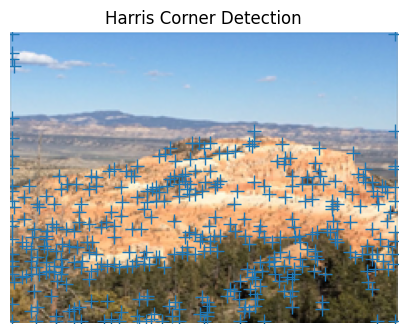

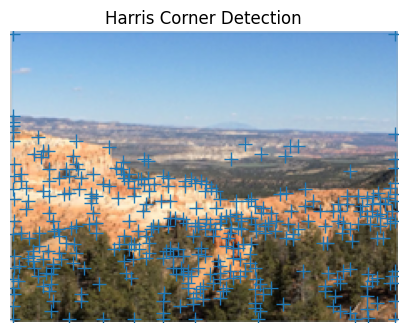

C:\Users\elif.yozkan\AppData\Local\Temp\ipykernel_11992\2093387401.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\elif.yozkan\AppData\Local\Temp\ipykernel_11992\2093387401.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, i+1)


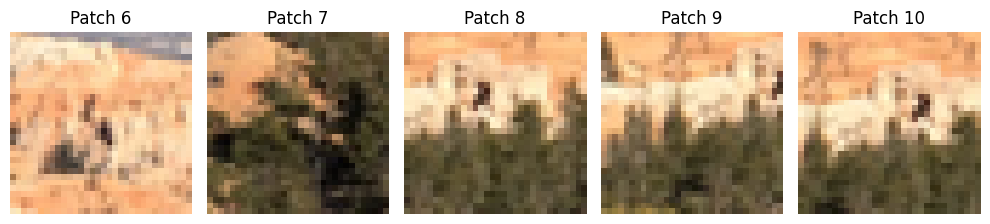

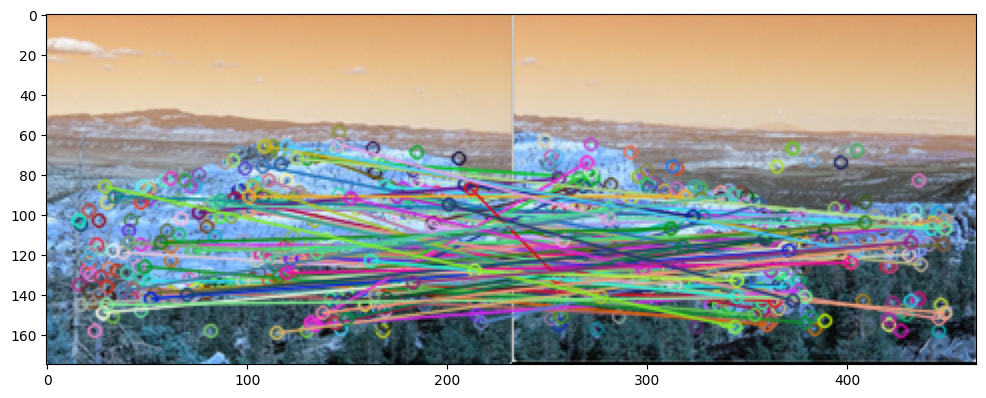

C:\Users\elif.yozkan\AppData\Local\Temp\ipykernel_11992\3255326538.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x,res,r,s= np.linalg.lstsq(A, b)


# of inliers:  44
# of outliers: 56
average residual:   0.336677353731431


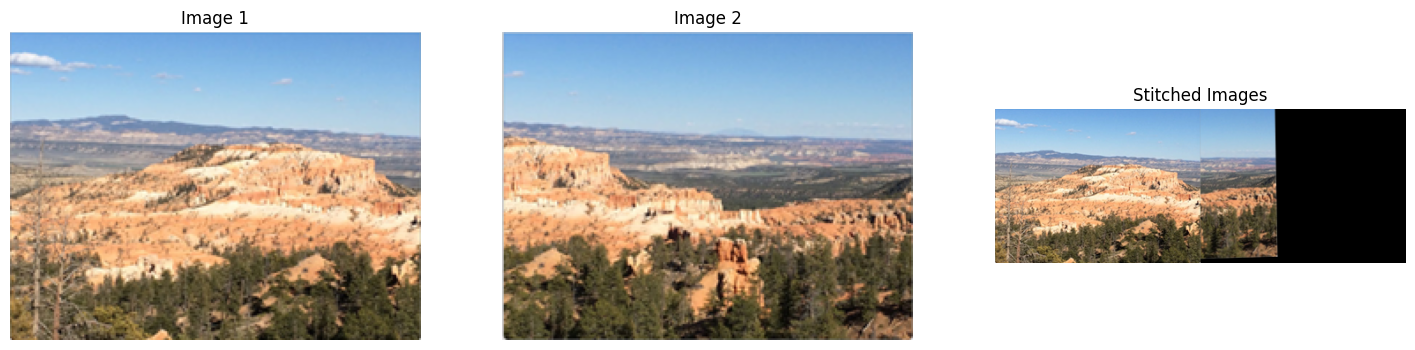

In [13]:
image_stiching(image,image2,patch_size=16,k=100)